In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr

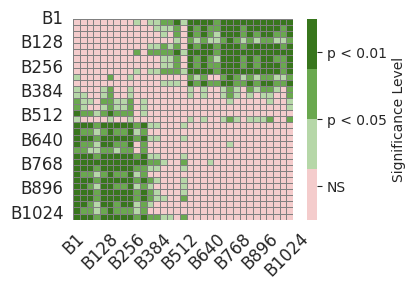

In [ ]:

from scipy.stats import mannwhitneyu
import matplotlib.colors as mcolors


fuzzers = ['afl', 'aflfast', 'aflplusplus', 'ecofuzz', 'fairfuzz', 
           'honggfuzz', 'lafintel', 'memlock-heap', 'memlock-stack', 'mopt', 'redqueen', 'tortoise-bb', 'tortoise-loop']

cmap = mcolors.ListedColormap(['#f4cccc', '#b6d7a8', '#6aa84f', '#38761d'])

def significance_label(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    else:
        return "NS"

for fuzzer in fuzzers:
    file_path = f'./reports/csvs/LOCATION/20241013/metrics/{fuzzer}.csv'
    
    data = pd.read_csv(file_path)
    
    programs = data['program'].unique()

    p_values_program_matrix = pd.DataFrame(np.ones((len(programs), len(programs))), index=programs, columns=programs)

    # Perform the Mann-Whitney U test between each pair of programs for the fuzzer 'ecofuzz'
    for i, program1 in enumerate(programs):
        for j, program2 in enumerate(programs):
            if i < j:  # Perform test only for upper triangle of matrix
                # Get duration data for both programs
                program1_data = data[(data['fuzzer'] == fuzzer) & (data['program'] == program1)]['duration']
                program2_data = data[(data['fuzzer'] == fuzzer) & (data['program'] == program2)]['duration']

                # Perform Mann-Whitney U test if both programs have data
                if not program1_data.empty and not program2_data.empty:
                    _, p_value = mannwhitneyu(program1_data, program2_data, alternative='two-sided')
                    # Update p-values matrix
                    p_values_program_matrix.loc[program1, program2] = p_value
                    p_values_program_matrix.loc[program2, program1] = p_value 

    # Apply significance labels to the matrix
    significance_program_matrix = p_values_program_matrix.applymap(significance_label)
    # significance_program_matrix

    data['B'] = data['program'].str.extract(r'B(\d+)$').astype(int)
    sorted_programs = data[['program', 'B']].drop_duplicates().sort_values('B')['program']

    # Update the significance matrix to the sorted order and rename programs to just 'B{value}'
    sorted_significance_matrix = significance_program_matrix.reindex(index=sorted_programs, columns=sorted_programs)
    sorted_significance_matrix.index = sorted_significance_matrix.columns = [f'B{num}' for num in sorted_programs.str.extract(r'B(\d+)$')[0]]

    # Map significance levels to numerical values again for the heatmap
    sorted_significance_numerical = sorted_significance_matrix.replace({
        "NS": 0, 
        "p < 0.05": 1, 
        "p < 0.01": 2, 
        "p < 0.001": 3
    })

    # Plot the heatmap
    plt.figure(figsize=(4.2, 3))
    sns.heatmap(sorted_significance_numerical, annot=False, fmt='', cmap=cmap, cbar=False, 
                linewidths=0.5, linecolor='gray')

    # Add color bar labels
    cbar_labels = ["NS", "p < 0.05", "p < 0.01"]
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks([0.5, 1.5, 2.5])
    cbar.set_ticklabels(cbar_labels)
    
    # Display limited ticks as per previous instructions
    tick_positions = range(0, len(sorted_significance_numerical), max(1, len(sorted_significance_numerical) // 8))
    tick_labels = [sorted_significance_numerical.index[i] for i in tick_positions]

    # Add labels and title
    plt.title(f"")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=12)
    plt.yticks(ticks=tick_positions, labels=tick_labels, rotation=0, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./reports/utest/{fuzzer}.pdf', format='pdf',dpi=300)
    plt.show()


In [ ]:
data = pd.read_csv('./reports/merged/PROB_20241028_merged_updated.csv')
df = data[data['W'] < 9]

grouped = df.groupby(['fuzzer', 'W'])

fuzzers = df['fuzzer'].unique()

correlation_results = {}

for fuzzer in fuzzers:
    fuzzer_data = df[df['fuzzer'] == fuzzer]
    
    W_values = []
    duration_values = []

    for W, durations in fuzzer_data.groupby('W')['duration']:
        W_values.extend([W] * len(durations)) 
        duration_values.extend(durations)

    correlation, p_value = spearmanr(W_values, duration_values)
    
    correlation_results[fuzzer] = {'spearman_correlation': correlation, 'p_value': p_value}

headers = ["Fuzzer", "Correlation", "P-value"]
values = []

for fuzzer, result in correlation_results.items():
    values.append((fuzzer, result['spearman_correlation'], result['p_value']))
    print(f"Fuzzer: {fuzzer}")
    print(f"Spearman Correlation: {result['spearman_correlation']}")
    print(f"P-value: {result['p_value']}\n")

with open('./reports/correlation/PROB.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(values)



Fuzzer: tortoise-loop
Spearman Correlation: -0.4095161918259541
P-value: 5.056966528660859e-07

Fuzzer: honggfuzz
Spearman Correlation: -0.09298588101969567
P-value: 0.27451273093433565

Fuzzer: redqueen
Spearman Correlation: -0.4515967928409119
P-value: 2.1397517528523782e-08

Fuzzer: afl
Spearman Correlation: -0.31533312274110414
P-value: 0.00014769816062678488

Fuzzer: mopt
Spearman Correlation: -0.1918382753750227
P-value: 0.023168587716876077

Fuzzer: ecofuzz
Spearman Correlation: -0.23717082451262844
P-value: 0.004780618590147813

Fuzzer: fairfuzz
Spearman Correlation: -0.3641473607128627
P-value: 9.740928712858048e-06

Fuzzer: memlock-stack
Spearman Correlation: -0.22849181255213794
P-value: 0.006620960565256439

Fuzzer: memlock-heap
Spearman Correlation: 0.06134063256576928
P-value: 0.471547497104123

Fuzzer: aflplusplus
Spearman Correlation: -0.5071732233629577
P-value: 1.6094574424656708e-10

Fuzzer: lafintel
Spearman Correlation: -0.29096096793745574
P-value: 0.0004873757177

/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/2940786583.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


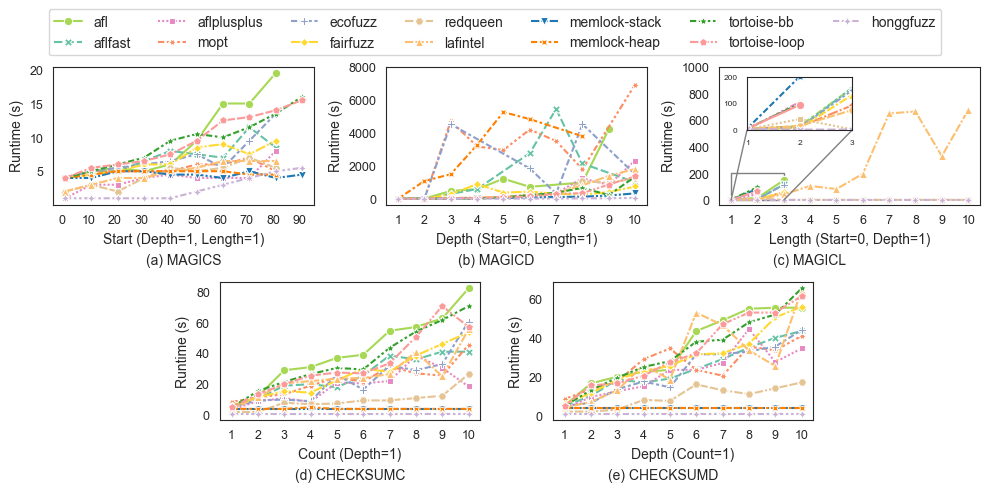

In [ ]:
color_mapping = {
    'afl': '#a6d854',            # Light Green
    'aflfast': '#66c2a5',        # Teal
    'aflplusplus': '#e78ac3',    # Pink
    'mopt': '#fc8d62',           # Coral
    'ecofuzz': '#8da0cb',        # Light Blue
    'fairfuzz': '#ffd92f',       # Yellow
    'redqueen': '#e5c494',       # Beige
    'lafintel': '#fdbf6f',       # Light Orange
    'memlock-stack': '#1f78b4',  # Dark Blue
    'memlock-heap': '#ff7f00',   # Orange
    'tortoise-bb': '#33a02c',    # Dark Green
    'tortoise-loop': '#fb9a99',  # Light Red
    'honggfuzz': '#cab2d6',      # Lavender
}

hue_order1 = [
    'afl',
    'aflfast',
    'aflplusplus', 
    'mopt',
    'ecofuzz',
    'fairfuzz',
    'redqueen',
    'lafintel',
    'memlock-stack',
    'memlock-heap',
    'tortoise-bb',
    'tortoise-loop',
    'honggfuzz'
    
]

sns.set_style("white")
fig = plt.figure(figsize=(10, 4.5))

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)

ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5) 

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax3.tick_params(labelsize=9)
ax4.tick_params(labelsize=9)
ax5.tick_params(labelsize=9)

filtered_data = pd.read_csv('./reports/merged/MAGICS_20241014_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
filtered_data1 = filtered_data1[filtered_data1['S'] <= 91]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'S'], as_index=False)['duration'].median()


sns.lineplot(x='S', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

ax1.set_ylabel('Runtime (s)', fontsize=10)
ax1.set_xlabel('Start (Depth=1, Length=1)', fontsize=10)
ax1.set_xticks(range(0, 91, 10))
ax1.get_legend().remove()

fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=7, fontsize=10)

filtered_data2 = pd.read_csv('./reports/merged/MAGICD_20241025_merged_updated.csv')
filtered_data2 = filtered_data2[filtered_data2['fuzzer'].isin(hue_order1)]
filtered_data2 = filtered_data2[filtered_data2['D'] <= 10]

median_data2 = filtered_data2.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data2, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax2, legend=False)

ax2.set_ylabel('Runtime (s)', fontsize=10)
ax2.set_xlabel('Depth (Start=0, Length=1)', fontsize=10)
ax2.set_xticks(range(1, 11, 1))
ax2.set_yticks(range(0, 8001, 2000))

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

filtered_data3 = pd.read_csv('./reports/merged/MAGICL_20241018_merged_updated.csv')
filtered_data3 = filtered_data3[filtered_data3['fuzzer'].isin(hue_order1)]

median_data3 = filtered_data3.groupby(['fuzzer', 'L'], as_index=False)['duration'].median()

sns.lineplot(x='L', y='duration', hue='fuzzer', 
             data=median_data3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_xticks(range(1, 11, 1))
ax3.set_yticks(range(0, 1001, 200))

ax3.set_ylabel('Runtime (s)', fontsize=10)
ax3.set_xlabel('Length (Start=0, Depth=1)', fontsize=10)

zoom_ax = zoomed_inset_axes(ax3, zoom=2, loc="upper left", 
                            bbox_to_anchor=(0.08, 0.98), 
                            bbox_transform=ax3.transAxes)
sns.lineplot(x='L', y='duration', hue='fuzzer', 
             data=filtered_data3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax, legend=False)

zoom_ax.set_ylabel('', fontsize=10)
zoom_ax.set_xlabel('', fontsize=10)

zoom_ax.set_xlim(1, 3)
zoom_ax.set_ylim(0, 200)

zoom_ax.set_xticks([1, 2, 3])
zoom_ax.tick_params(labelsize=6)

mark_inset(ax3, zoom_ax, loc1=3, loc2=4, fc="none", ec="0.5")

ax1.text(0.5, -0.35, "(a) MAGICS", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax2.text(1.7, -0.35, "(b) MAGICD", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax3.text(2.9, -0.35, "(c) MAGICL", ha='center', va='top', transform=ax1.transAxes, fontsize=10)

filtered_data4 = pd.read_csv('./reports/merged/HARD_20241023_merged_updated.csv')
filtered_data4 = filtered_data4[filtered_data4['fuzzer'].isin(hue_order1)]
filtered_data5 = filtered_data4[filtered_data4['D'] == 1]
filtered_data6 = filtered_data4[filtered_data4['C'] == 1]
   
median_data5 = filtered_data5.groupby(['fuzzer', 'C'], as_index=False)['duration'].median()
median_data6 = filtered_data6.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='C', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax4, legend=False)

ax4.set_ylabel('Runtime (s)', fontsize=10)
ax4.set_xlabel('Count (Depth=1)', fontsize=10)
ax4.set_xticks(range(1, 11, 1))

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax5, legend=False)

ax5.set_ylabel('Runtime (s)', fontsize=10)
ax5.set_xticks(range(1, 11, 1))
ax5.set_xlabel('Depth (Count=1)', fontsize=10)

ax4.text(0.5, -0.35, "(d) CHECKSUMC", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax5.text(1.7, -0.35, "(e) CHECKSUMD", ha='center', va='top', transform=ax4.transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('./reports/paper/data-flow.pdf', format='pdf', bbox_inches='tight', dpi=300)


/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/2803417802.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


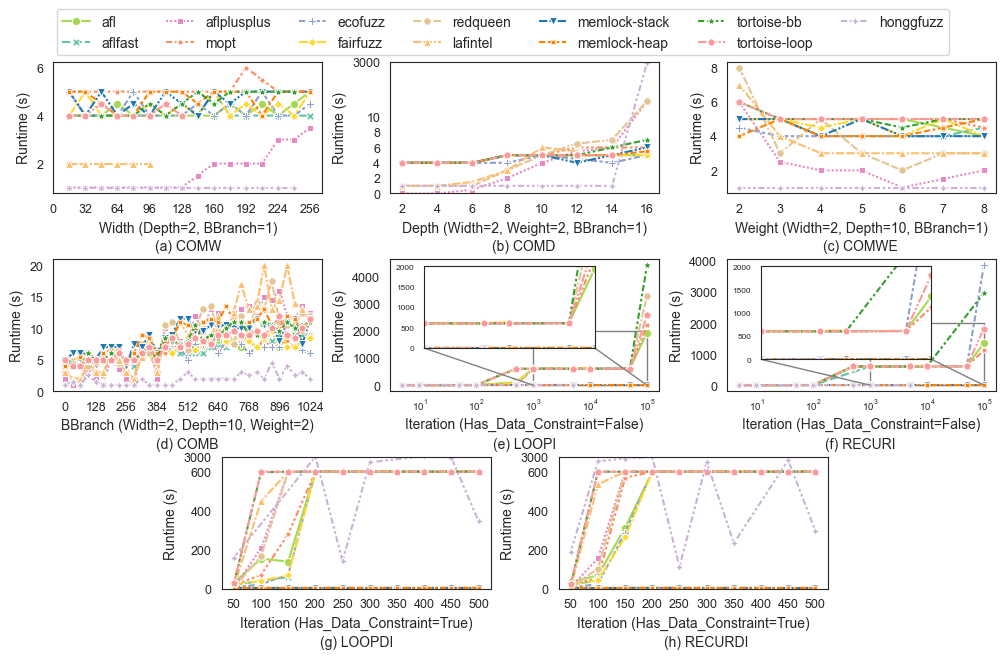

In [ ]:
color_mapping = {
    'afl': '#a6d854',            # Light Green
    'aflfast': '#66c2a5',        # Teal
    'aflplusplus': '#e78ac3',    # Pink
    'mopt': '#fc8d62',           # Coral
    'ecofuzz': '#8da0cb',        # Light Blue
    'fairfuzz': '#ffd92f',       # Yellow
    'redqueen': '#e5c494',       # Beige
    'lafintel': '#fdbf6f',       # Light Orange
    'memlock-stack': '#1f78b4',  # Dark Blue
    'memlock-heap': '#ff7f00',   # Orange
    'tortoise-bb': '#33a02c',    # Dark Green
    'tortoise-loop': '#fb9a99',  # Light Red
    'honggfuzz': '#cab2d6',      # Lavender
}

hue_order1 = [
    'afl',
    'aflfast',
    'aflplusplus', 
    'mopt',
    'ecofuzz',
    'fairfuzz',
    'redqueen',
    'lafintel',
    'memlock-stack',
    'memlock-heap',
    'tortoise-bb',
    'tortoise-loop',
    'honggfuzz'
]

sns.set_style("white")
fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((3, 6), (0, 4), colspan=2)

ax4 = plt.subplot2grid((3, 6), (1, 0), colspan=2)
ax5 = plt.subplot2grid((3, 6), (1, 2), colspan=2)
ax6 = plt.subplot2grid((3, 6), (1, 4), colspan=2)

ax7 = plt.subplot2grid((3, 6), (2, 1), colspan=2)
ax8 = plt.subplot2grid((3, 6), (2, 3), colspan=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5) 

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax3.tick_params(labelsize=9)
ax4.tick_params(labelsize=9)
ax5.tick_params(labelsize=9)
ax6.tick_params(labelsize=9)
ax7.tick_params(labelsize=9)
ax8.tick_params(labelsize=9)

filtered_data = pd.read_csv('./reports/merged/COMPW_20241017_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

ax1.set_ylabel('Runtime (s)', fontsize=10)
ax1.set_xlabel('Width (Depth=2, BBranch=1)', fontsize=10)
ax1.set_xticks(range(0, 257, 32))
ax1.get_legend().remove()

fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=7, fontsize=10)

filtered_data2 = pd.read_csv('./reports/merged/COMPD_20241012_merged_updated.csv')
filtered_data2 = filtered_data2[filtered_data2['fuzzer'].isin(hue_order1)]

median_data2 = filtered_data2.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data2, palette=color_mapping, 
             errorbar='sd', markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax2, legend=False)

ax2.set_yscale('symlog', linthresh=12, linscale=5)
ax2.set_ylim(0, 3000)
ax2.set_yticks([0, 2, 4, 6, 8, 10, 3000])
ax2.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax2.set_xlabel('Depth (Width=2, Weight=2, BBranch=1)', fontsize=10)
ax2.set_ylabel('Runtime (s)', fontsize=10)
ax2.set_xticks(range(2, 17, 2))

filtered_data3 = pd.read_csv('./reports/merged/PROB_20241028_merged_updated.csv')
filtered_data3 = filtered_data3[filtered_data3['W'] < 9]
filtered_data3 = filtered_data3[filtered_data3['fuzzer'].isin(hue_order1)]

median3 = filtered_data3.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_ylabel('Runtime (s)', fontsize=10)
ax3.set_xlabel('Weight (Width=2, Depth=10, BBranch=1)', fontsize=10)

filtered_data4 = pd.read_csv('./reports/merged/LOCATION_20241013_merged_updated.csv')
filtered_data4 = filtered_data4[filtered_data4['fuzzer'].isin(hue_order1)]
   
median_data4 = filtered_data4.groupby(['fuzzer', 'B'], as_index=False)['duration'].median()

sns.lineplot(x='B', y='duration', hue='fuzzer', 
             data=median_data4, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax4, legend=False)

ax4.set_ylabel('Runtime (s)', fontsize=10)
ax4.set_xlabel('BBranch (Width=2, Depth=10, Weight=2)', fontsize=10)
ax4.set_xticks(range(0, 1025, 128))
ax4.set_yticks([0, 5, 10, 15, 20])

filtered_data5 = pd.read_csv('./reports/merged/LOOP_20241019_merged_updated.csv')
filtered_data5 = filtered_data5[filtered_data5['fuzzer'].isin(hue_order1)]
   
median_data5 = filtered_data5.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax5, legend=False)

ax5.set_ylabel('Runtime (s)', fontsize=10)
ax5.set_xlabel('Iteration (Has_Data_Constraint=False)', fontsize=10)
ax5.tick_params(axis="x", labelsize=7, pad=0)
ax5.set_xscale('log')

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

zoom_ax5 = zoomed_inset_axes(ax5, zoom=1.5, loc="upper left", 
                            bbox_to_anchor=(0.1, 1), 
                            bbox_transform=ax5.transAxes)
sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax5, legend=False)

zoom_ax5.set_ylabel('', fontsize=10)
zoom_ax5.set_xlabel('', fontsize=10)
zoom_ax5.set_xscale('log')

zoom_ax5.set_xlim(1000, 100000)
zoom_ax5.set_ylim(0, 2000)

zoom_ax5.tick_params(labelsize=6)
zoom_ax5.tick_params(axis="x", labelbottom=False)

mark_inset(ax5, zoom_ax5, loc1=3, loc2=4, fc="none", ec="0.5")

filtered_data6 = pd.read_csv('./reports/merged/RECUR_20241019_merged_updated.csv')
filtered_data6 = filtered_data6[filtered_data6['fuzzer'].isin(hue_order1)]

median_data6 = filtered_data6.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax6, legend=False)

ax6.set_ylabel('Runtime (s)', fontsize=10)
ax6.set_xscale('log')
ax6.tick_params(axis="x", labelsize=7, pad=0)
ax6.set_xlabel('Iteration (Has_Data_Constraint=False)', fontsize=10)

zoom_ax6 = zoomed_inset_axes(ax6, zoom=1.5, loc="upper left", 
                            bbox_to_anchor=(0.1, 1), 
                            bbox_transform=ax6.transAxes)
sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax6, legend=False)

zoom_ax6.set_ylabel('', fontsize=10)
zoom_ax6.set_xlabel('', fontsize=10)
zoom_ax6.set_xscale('log')

zoom_ax6.set_xlim(1000, 100000)
zoom_ax6.set_ylim(0, 2000)

zoom_ax6.tick_params(labelsize=6)
zoom_ax6.tick_params(axis="x", labelbottom=False)

mark_inset(ax6, zoom_ax6, loc1=3, loc2=4, fc="none", ec="0.5")

filtered_data7 = pd.read_csv('./reports/merged/LOOPD_20241019_merged_updated.csv')
filtered_data7 = filtered_data7[filtered_data7['fuzzer'].isin(hue_order1)]
   
median_data7 = filtered_data7.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data7, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax7, legend=False)

ax7.set_yscale('symlog', linthresh=600, linscale=5)
ax7.set_ylim(0, 3000)
ax7.set_yticks([0, 200, 400, 600, 3000])
ax7.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax7.set_ylabel('Runtime (s)', fontsize=10)
ax7.set_xlabel('Iteration (Has_Data_Constraint=True)', fontsize=10)
ax7.set_xticks(range(50, 501, 50))

filtered_data8 = pd.read_csv('./reports/merged/RECURD_20241023_merged_updated.csv')
filtered_data8 = filtered_data8[filtered_data8['fuzzer'].isin(hue_order1)]

median_data8 = filtered_data8.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data8, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax8, legend=False)

ax8.set_yscale('symlog', linthresh=600, linscale=5)
ax8.set_ylim(0, 3000)
ax8.set_yticks([0, 200, 400, 600, 3000])
ax8.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax8.set_ylabel('Runtime (s)', fontsize=10)
ax8.set_xlabel('Iteration (Has_Data_Constraint=True)', fontsize=10)
ax8.set_xticks(range(50, 501, 50))

ax1.text(0.5, -0.35, "(a) COMW", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax2.text(1.75, -0.35, "(b) COMD", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax3.text(3, -0.35, "(c) COMWE", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax4.text(0.5, -0.35, "(d) COMB", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax5.text(1.75, -0.35, "(e) LOOPI", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax6.text(3, -0.35, "(f) RECURI", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax7.text(0.5, -0.35, "(g) LOOPDI", ha='center', va='top', transform=ax7.transAxes, fontsize=10)
ax8.text(1.8, -0.35, "(h) RECURDI", ha='center', va='top', transform=ax7.transAxes, fontsize=10)

plt.tight_layout(pad=0.5)
plt.savefig('./reports/paper/control-flow-new.pdf', format='pdf', bbox_inches='tight', dpi=300)